<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Jet_Classification_with_different_Initialization_Techniques_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane h5py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.0 MB/s eta 0:00:00


In [2]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Cell 2: Configuration / Hyperparameter Setup ---
@dataclass
class Config:
    SAMPLES: int = 5000  # Reduced dataset size
    NUM_QUBITS: int = 4  # Reduced number of qubits
    Q_DEPTH: int = 2  # Reduced circuit depth
    ENCODING_SCHEME: str = 'angle'  # Keep angle encoding for simplicity
    USE_ANALYTIC_GRADIENTS: bool = True
    CNN_OUTPUT_DIM: int = 512  # Increased CNN output dimension
    USE_PRETRAINED_CNN: bool = True
    INNER_STEPS: int = 4  # Reduced inner-loop adaptation steps
    INNER_LR: float = 0.005
    OUTER_LR: float = 0.0003  # Reduced outer learning rate
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 5  # Reduced number of bins
    SUPPORT_SIZE: int = 24
    QUERY_SIZE: int = 24
    EPOCHS: int = 10  # Reduced number of epochs
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = True
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [7]:
# --- Cell 3: Dataset Loading ---
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and return separate train and test datasets."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'

    # Load train dataset
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    # Load test dataset
    with h5py.File(test1_path, 'r') as f:
        X_test = f['X_jets'][:config.SAMPLES]
        y_test = f['y'][:config.SAMPLES]
        pt_test = f['pt'][:config.SAMPLES]
        m0_test = f['m0'][:config.SAMPLES]

    # Create train and test datasets
    train_dataset = JetDataset(X_train, y_train, pt_train, m0_train)
    test_dataset = JetDataset(X_test, y_test, pt_test, m0_test)

    return train_dataset, test_dataset

# Load train and test datasets
train_dataset, test_dataset = load_datasets(config)


In [8]:
# --- Cell 4: Meta-Task Generation ---
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_types: List[str],  # List of meta-task types (e.g., ['pt', 'm0'])
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    Args:
        dataset: The dataset containing jet images and features.
        meta_task_types: List of meta-task types to use (e.g., ['pt', 'm0']).
        bin_count: Number of bins for meta-task generation.
        support_size: Size of the support set.
        query_size: Size of the query set.
        num_tasks_per_bin: Number of tasks to generate per bin.
    Returns:
        List of meta-tasks, each containing support and query sets.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in meta_task_types:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                continue  # Skip bins with insufficient samples

            # Ensure balanced classes in support and query sets
            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]
            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                continue  # Skip bins with insufficient samples for balanced classes

            for _ in range(num_tasks_per_bin):
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False),
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False),
                ])
                meta_tasks.append({
                    "support_X": torch.tensor(X[support_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                    "query_X": torch.tensor(X[query_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                })
            bin_task_counts.append(num_tasks_per_bin)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks

# Generate meta-tasks using both `pt` and `m0`
meta_task_types = ['pt', 'm0']  # Use both features for meta-task generation
meta_tasks = generate_meta_tasks(
    train_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

Total meta-tasks generated: 21


In [9]:
# --- Cell 5: CNN Feature Extractor ---
class CNNFeatureExtractor(nn.Module):
    """CNN-based feature extractor using pretrained ResNet-18."""
    def __init__(self, output_dim: int, num_qubits: int):
        super(CNNFeatureExtractor, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, output_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(output_dim, num_qubits)  # Use num_qubits passed as an argument
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# Instantiate the CNN feature extractor with the correct arguments
cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [10]:
# --- Cell 6: PQC Model ---
class PQCModel(nn.Module):
    """Parameterized Quantum Circuit (PQC) model."""
    def __init__(self, num_qubits: int, depth: int, init_type: str = "qmaml"):
        super(PQCModel, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
            # Angle encoding
            for i in range(num_qubits):
                qml.RY(inputs[i], wires=i)
            # Variational layers
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))  # Expectation value of Z on the first qubit

        self.circuit = circuit

        # Initialize weights based on init_type
        if init_type == "zero":
            self.weights = nn.Parameter(torch.zeros(depth, num_qubits, 3))
        elif init_type == "pi":
            self.weights = nn.Parameter(torch.full((depth, num_qubits, 3), np.pi))
        elif init_type == "uniform":
            self.weights = nn.Parameter(torch.rand(depth, num_qubits, 3) * 0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1 / (4 * num_qubits * (depth + 2))
            self.weights = nn.Parameter(torch.normal(0, gamma, size=(depth, num_qubits, 3)))
        else:  # Default to QMAML initialization
            self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))

        self.fc = nn.Linear(1, 2)  # Map scalar output to two logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)  # Placeholder for quantum outputs
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits

In [11]:
# --- Cell 7: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [12]:
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> Tuple[nn.Module, List[float]]:
    """
    Perform inner-loop adaptation on the support set and track gradient norms.
    Returns the adapted model and a list of gradient norms for each step.
    """
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()

    gradient_norms = []  # Track gradient norms

    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()

        # Calculate and store the L2 norm of gradients
        grad_norm = 0.0
        for param in adapted_model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.norm(2).item() ** 2
        gradient_norms.append(grad_norm ** 0.5)

        optimizer.step()

    return adapted_model, gradient_norms

In [13]:
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],  # Unseen meta-tasks for generalization
    outer_lr: float,
    eval_metrics: bool,
) -> Dict[str, List[float]]:
    """
    Perform outer-loop meta-update using meta-tasks and test generalization on unseen tasks.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    # History tracking
    meta_loss_history = []
    gradient_norm_history = []  # Track gradient norms
    metrics_history = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
    }
    test_metrics_history = {  # For unseen tasks
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
    }

    best_accuracy = 0.0  # For saving the best model

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1s = [], [], [], []
        epoch_gradient_norms = []  # Track gradient norms for this epoch

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model, gradient_norms = inner_loop_adaptation(
                model, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            epoch_gradient_norms.extend(gradient_norms)

            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()

            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()

            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = (preds == task["query_y"]).float().mean().item()
                precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                epoch_accuracies.append(accuracy)
                epoch_precisions.append(precision)
                epoch_recalls.append(recall)
                epoch_f1s.append(f1)

        # Store per-epoch meta-loss and gradient norms
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)
        gradient_norm_history.append(np.mean(epoch_gradient_norms))

        # Store average metrics for this epoch
        if eval_metrics:
            avg_accuracy = np.mean(epoch_accuracies) if epoch_accuracies else 0.0
            avg_precision = np.mean(epoch_precisions) if epoch_precisions else 0.0
            avg_recall = np.mean(epoch_recalls) if epoch_recalls else 0.0
            avg_f1 = np.mean(epoch_f1s) if epoch_f1s else 0.0
            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

            # Save the best model based on accuracy
            if config.SAVE_BEST_MODEL and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        # Test generalization on unseen meta-tasks
        if eval_metrics:
            test_accuracies, test_precisions, test_recalls, test_f1s = [], [], [], []
            for test_task in test_meta_tasks:
                query_logits = model(test_task["query_X"])
                preds = torch.argmax(query_logits, dim=1)
                test_accuracies.append((preds == test_task["query_y"]).float().mean().item())
                test_precisions.append(
                    precision_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0)
                )
                test_recalls.append(
                    recall_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0)
                )
                test_f1s.append(f1_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0))

            test_metrics_history["accuracy"].append(np.mean(test_accuracies))
            test_metrics_history["precision"].append(np.mean(test_precisions))
            test_metrics_history["recall"].append(np.mean(test_recalls))
            test_metrics_history["f1_score"].append(np.mean(test_f1s))

        # Print epoch summary
        print(
            f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, "
            f"Accuracy: {avg_accuracy:.4f}, Test Accuracy: {test_metrics_history['accuracy'][-1]:.4f}"
        )

    return {
        "meta_loss": meta_loss_history,
        "gradient_norms": gradient_norm_history,
        **metrics_history,
        "test_metrics": test_metrics_history,
    }

In [14]:
# --- Cell 10: Evaluation and Visualization ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    """
    Plot training results including meta-loss, accuracy, and gradient norms.
    """
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracy
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot gradient norms
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["gradient_norms"], label="Gradient Norms", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Gradient Norms")
    plt.title(f"Gradient Norms over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    """Compare meta-loss and accuracy across all initialization techniques."""
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Compare meta-loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare accuracy across initializations
    if config.EVAL_METRICS:
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["accuracy"], label=f"{init_type.capitalize()} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Comparison Across Initializations")
        plt.legend()
        plt.grid(True)
        plt.show()

Total meta-tasks generated: 24
Testing initialization: qmaml
Epoch 1/10, Meta-loss: 0.7483, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.6601, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 3/10, Meta-loss: 0.5611, Accuracy: 0.7024, Test Accuracy: 0.6580
Epoch 4/10, Meta-loss: 0.5481, Accuracy: 0.8016, Test Accuracy: 0.6649
Epoch 5/10, Meta-loss: 0.5163, Accuracy: 0.8214, Test Accuracy: 0.6528
Epoch 6/10, Meta-loss: 0.4586, Accuracy: 0.8591, Test Accuracy: 0.6684
Epoch 7/10, Meta-loss: 0.4534, Accuracy: 0.8532, Test Accuracy: 0.6528
Epoch 8/10, Meta-loss: 0.4528, Accuracy: 0.8274, Test Accuracy: 0.6753
Epoch 9/10, Meta-loss: 0.4122, Accuracy: 0.8571, Test Accuracy: 0.6441
Epoch 10/10, Meta-loss: 0.4311, Accuracy: 0.8452, Test Accuracy: 0.6806


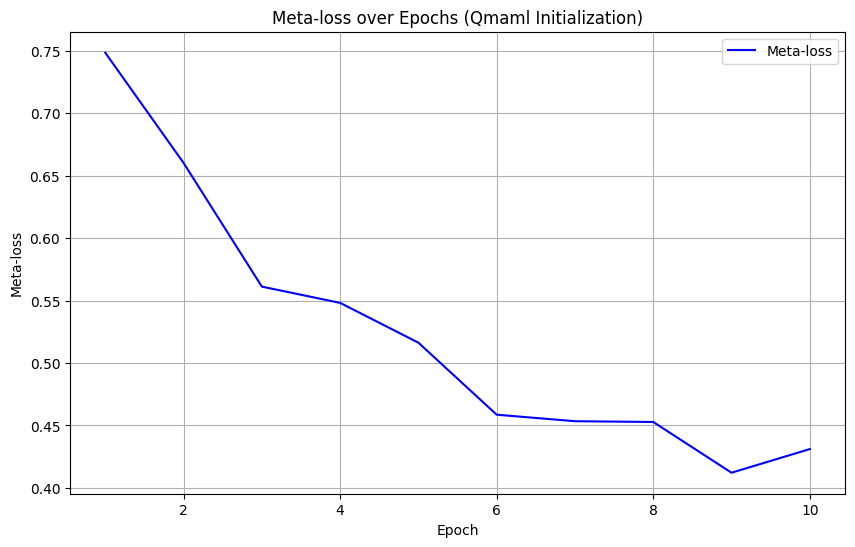

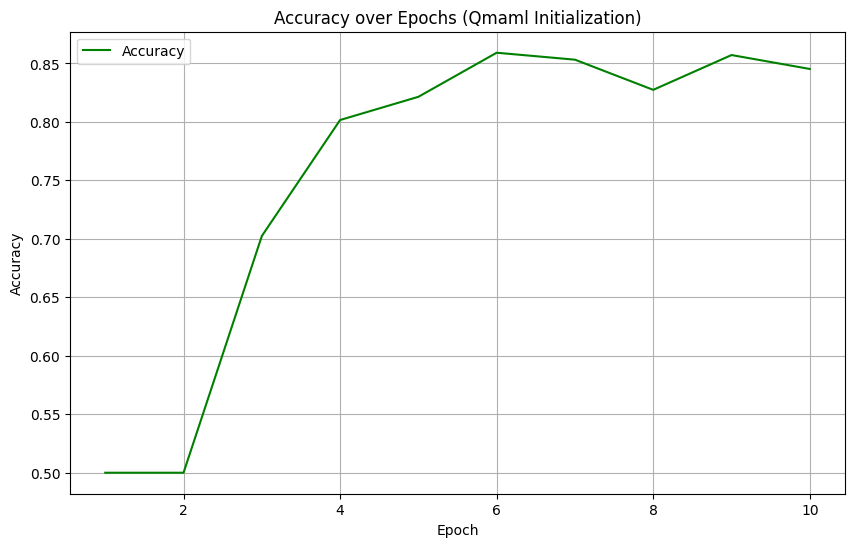

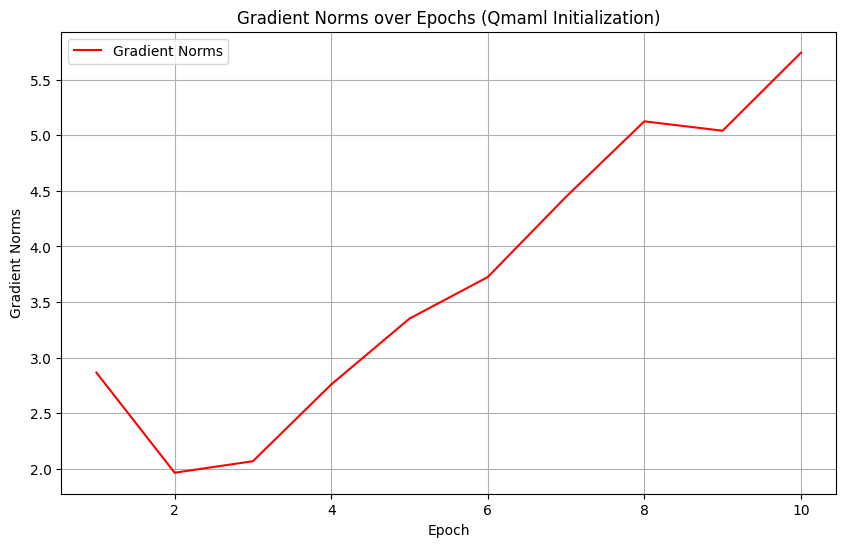

Testing initialization: zero
Epoch 1/10, Meta-loss: 0.6121, Accuracy: 0.6389, Test Accuracy: 0.6406
Epoch 2/10, Meta-loss: 0.5567, Accuracy: 0.7460, Test Accuracy: 0.6458
Epoch 3/10, Meta-loss: 0.5308, Accuracy: 0.7540, Test Accuracy: 0.6649
Epoch 4/10, Meta-loss: 0.5184, Accuracy: 0.7639, Test Accuracy: 0.6319
Epoch 5/10, Meta-loss: 0.5423, Accuracy: 0.7321, Test Accuracy: 0.6163
Epoch 6/10, Meta-loss: 0.5418, Accuracy: 0.7500, Test Accuracy: 0.6319
Epoch 7/10, Meta-loss: 0.5097, Accuracy: 0.8135, Test Accuracy: 0.6076
Epoch 8/10, Meta-loss: 0.4756, Accuracy: 0.8175, Test Accuracy: 0.6111
Epoch 9/10, Meta-loss: 0.4761, Accuracy: 0.7897, Test Accuracy: 0.6128
Epoch 10/10, Meta-loss: 0.5533, Accuracy: 0.7083, Test Accuracy: 0.6146


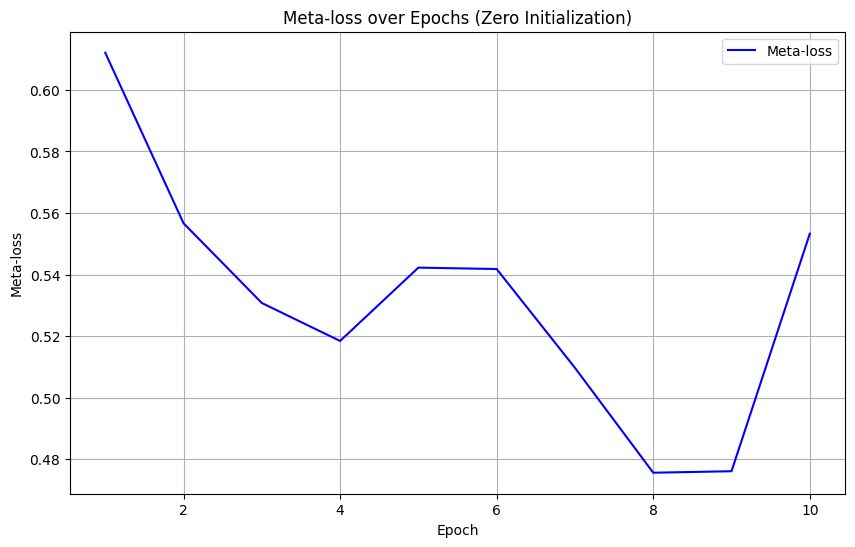

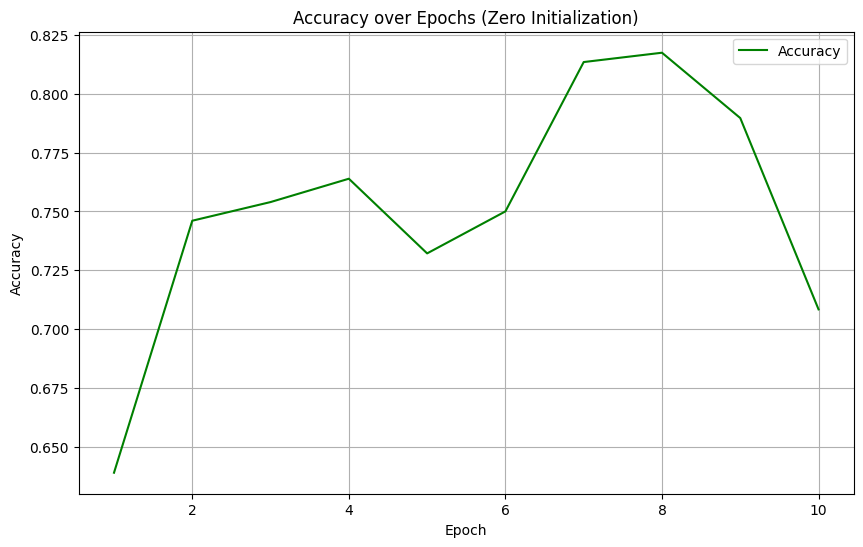

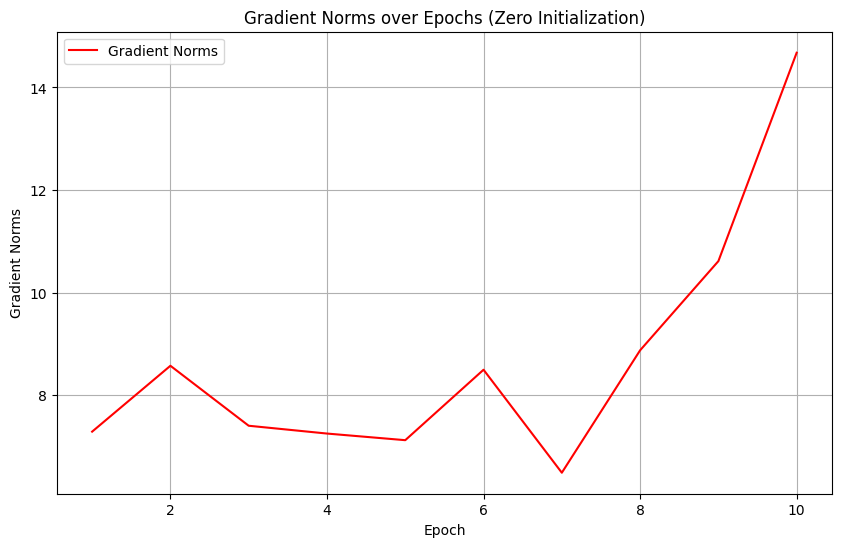

Testing initialization: pi
Epoch 1/10, Meta-loss: 0.8110, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.7681, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 3/10, Meta-loss: 0.7443, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 4/10, Meta-loss: 0.7206, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 5/10, Meta-loss: 0.6987, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 6/10, Meta-loss: 0.6773, Accuracy: 0.5575, Test Accuracy: 0.6319
Epoch 7/10, Meta-loss: 0.6711, Accuracy: 0.6786, Test Accuracy: 0.5955
Epoch 8/10, Meta-loss: 0.6729, Accuracy: 0.6131, Test Accuracy: 0.5990
Epoch 9/10, Meta-loss: 0.6593, Accuracy: 0.6687, Test Accuracy: 0.5833
Epoch 10/10, Meta-loss: 0.6341, Accuracy: 0.7421, Test Accuracy: 0.6250


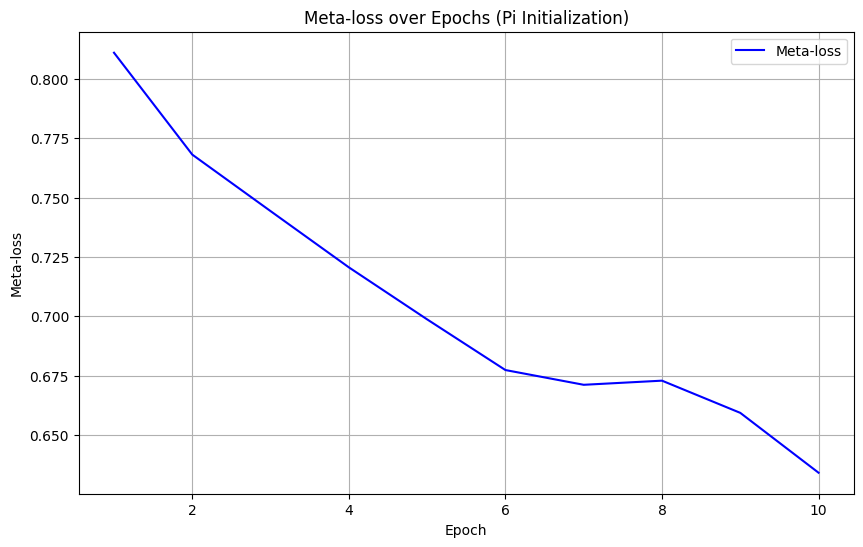

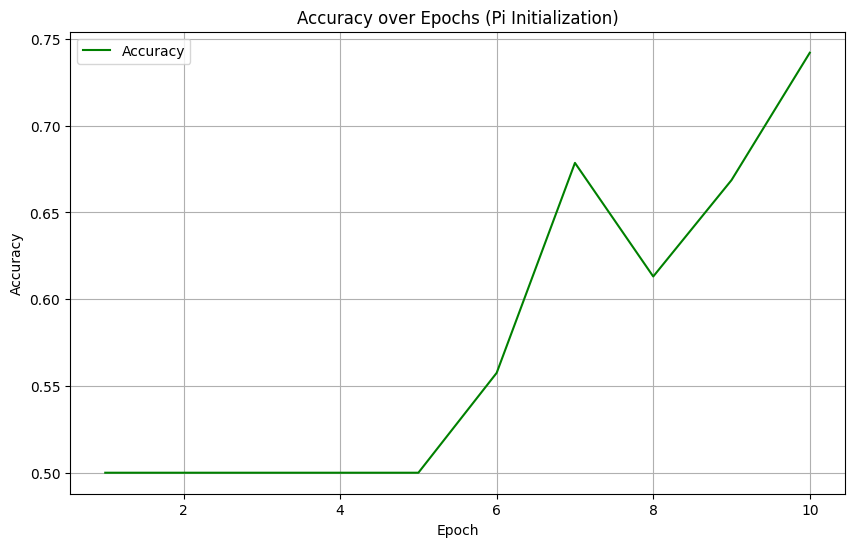

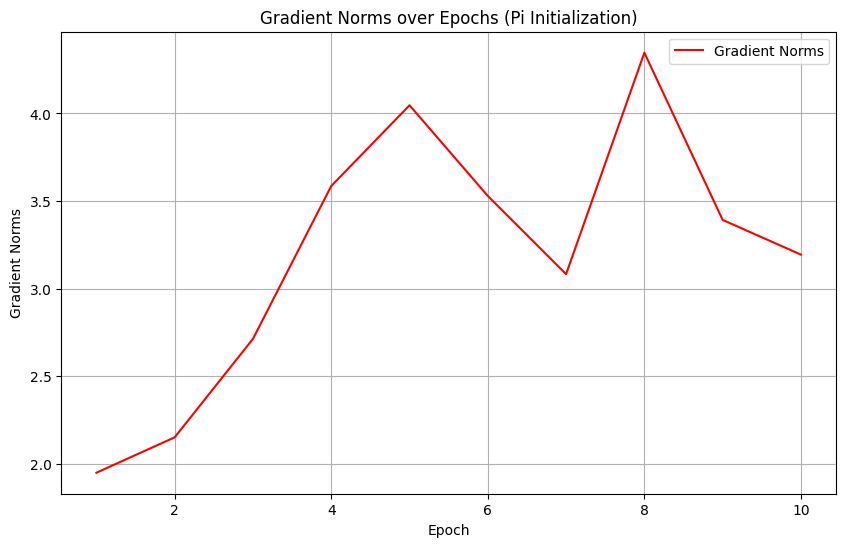

Testing initialization: uniform
Epoch 1/10, Meta-loss: 0.8831, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.7611, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 3/10, Meta-loss: 0.7046, Accuracy: 0.5139, Test Accuracy: 0.5174
Epoch 4/10, Meta-loss: 0.6915, Accuracy: 0.5179, Test Accuracy: 0.5573
Epoch 5/10, Meta-loss: 0.6587, Accuracy: 0.6032, Test Accuracy: 0.6059
Epoch 6/10, Meta-loss: 0.6634, Accuracy: 0.6032, Test Accuracy: 0.5729
Epoch 7/10, Meta-loss: 0.6601, Accuracy: 0.6171, Test Accuracy: 0.5694
Epoch 8/10, Meta-loss: 0.6720, Accuracy: 0.5853, Test Accuracy: 0.5799
Epoch 9/10, Meta-loss: 0.6736, Accuracy: 0.5794, Test Accuracy: 0.5990
Epoch 10/10, Meta-loss: 0.6727, Accuracy: 0.5992, Test Accuracy: 0.5851


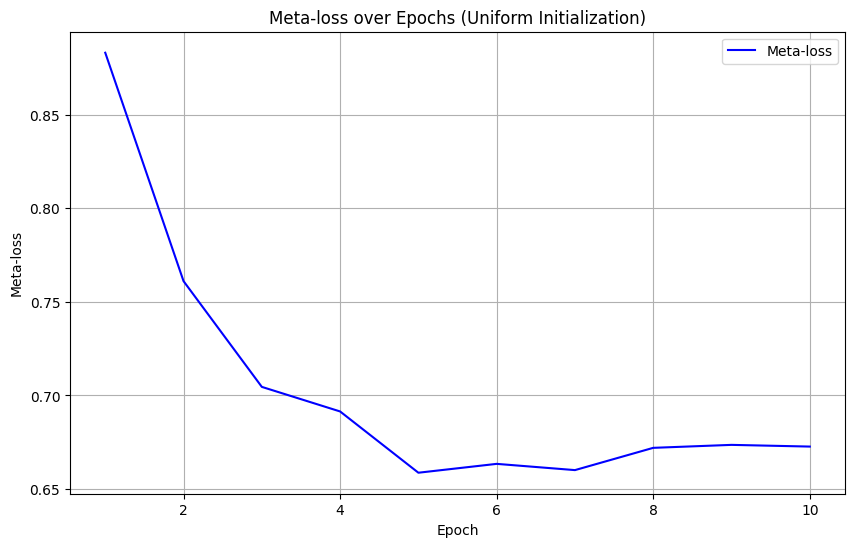

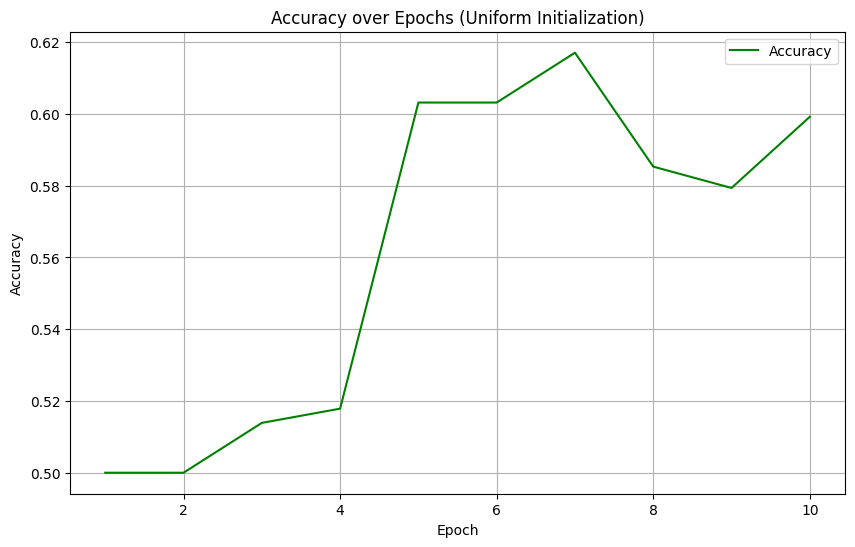

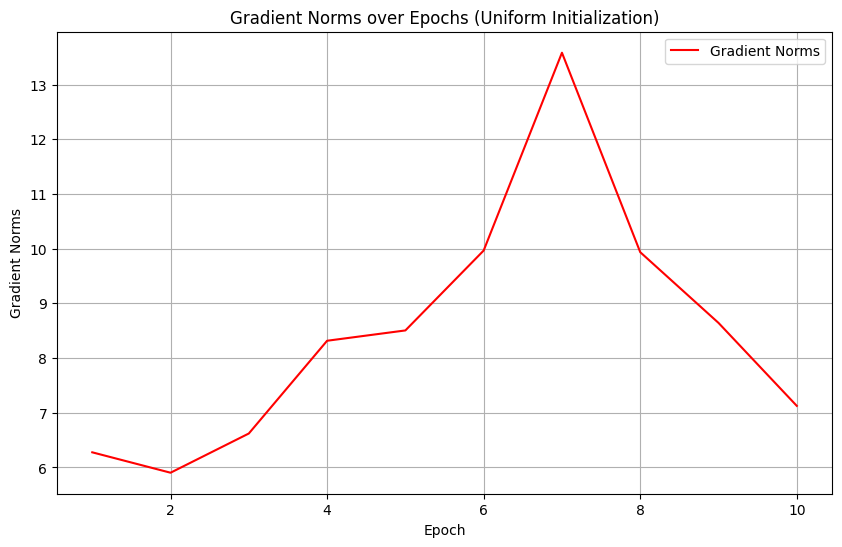

Testing initialization: gaussian
Epoch 1/10, Meta-loss: 0.6743, Accuracy: 0.5933, Test Accuracy: 0.5330
Epoch 2/10, Meta-loss: 0.6799, Accuracy: 0.5357, Test Accuracy: 0.5521
Epoch 3/10, Meta-loss: 0.6679, Accuracy: 0.6052, Test Accuracy: 0.5608
Epoch 4/10, Meta-loss: 0.6753, Accuracy: 0.5635, Test Accuracy: 0.5920
Epoch 5/10, Meta-loss: 0.6745, Accuracy: 0.5972, Test Accuracy: 0.5660
Epoch 6/10, Meta-loss: 0.6661, Accuracy: 0.5933, Test Accuracy: 0.6007
Epoch 7/10, Meta-loss: 0.6641, Accuracy: 0.6250, Test Accuracy: 0.5816
Epoch 8/10, Meta-loss: 0.6560, Accuracy: 0.6389, Test Accuracy: 0.5937
Epoch 9/10, Meta-loss: 0.6552, Accuracy: 0.6032, Test Accuracy: 0.6024
Epoch 10/10, Meta-loss: 0.6404, Accuracy: 0.6448, Test Accuracy: 0.5885


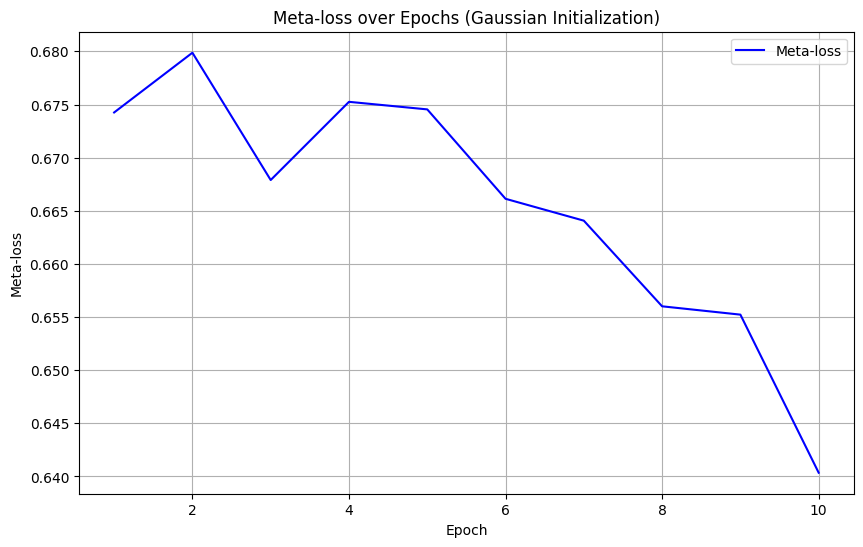

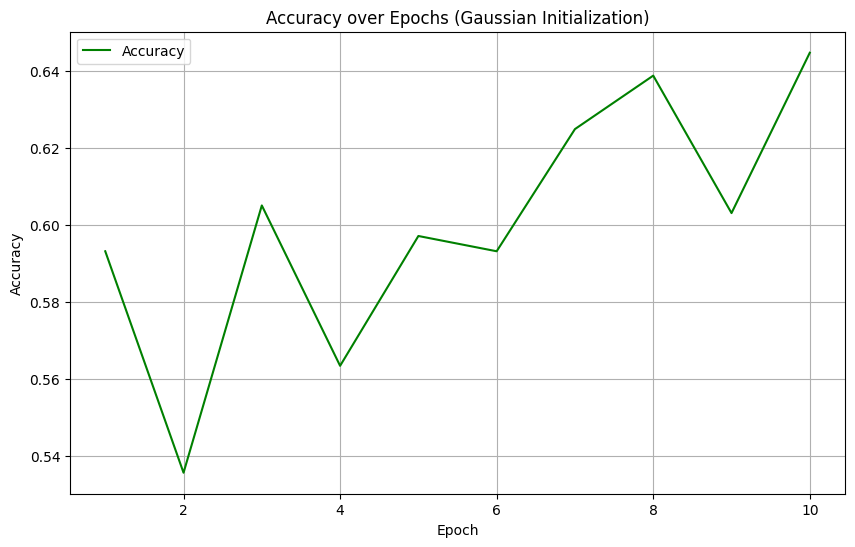

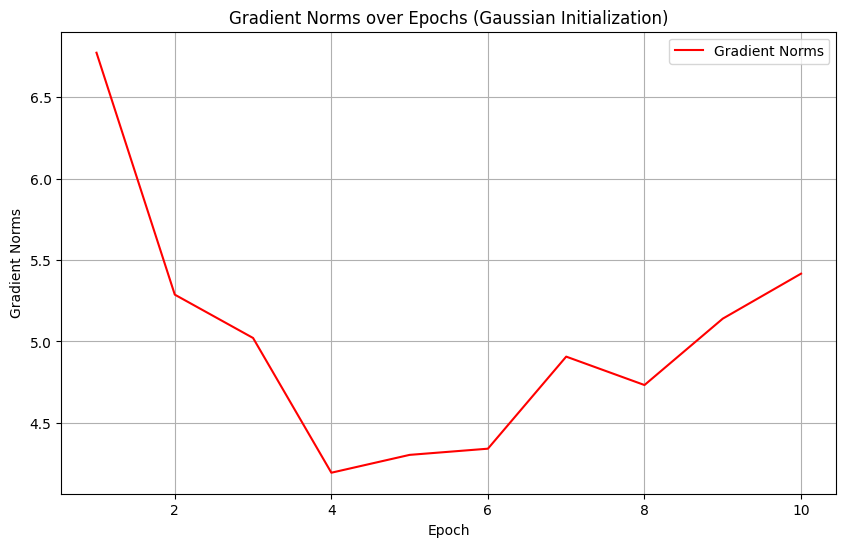

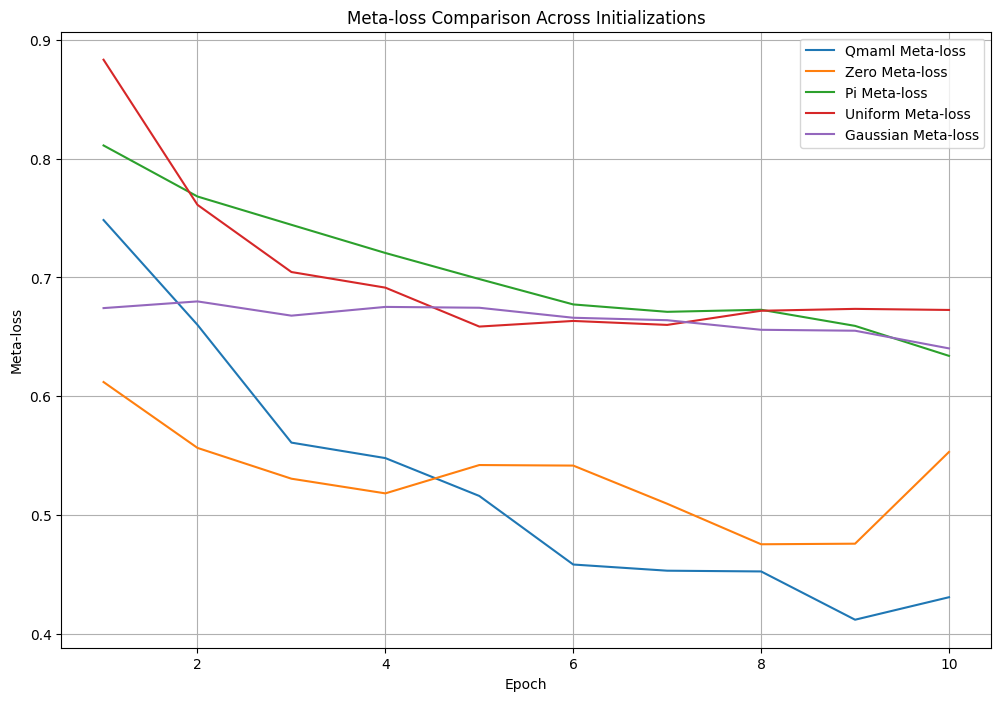

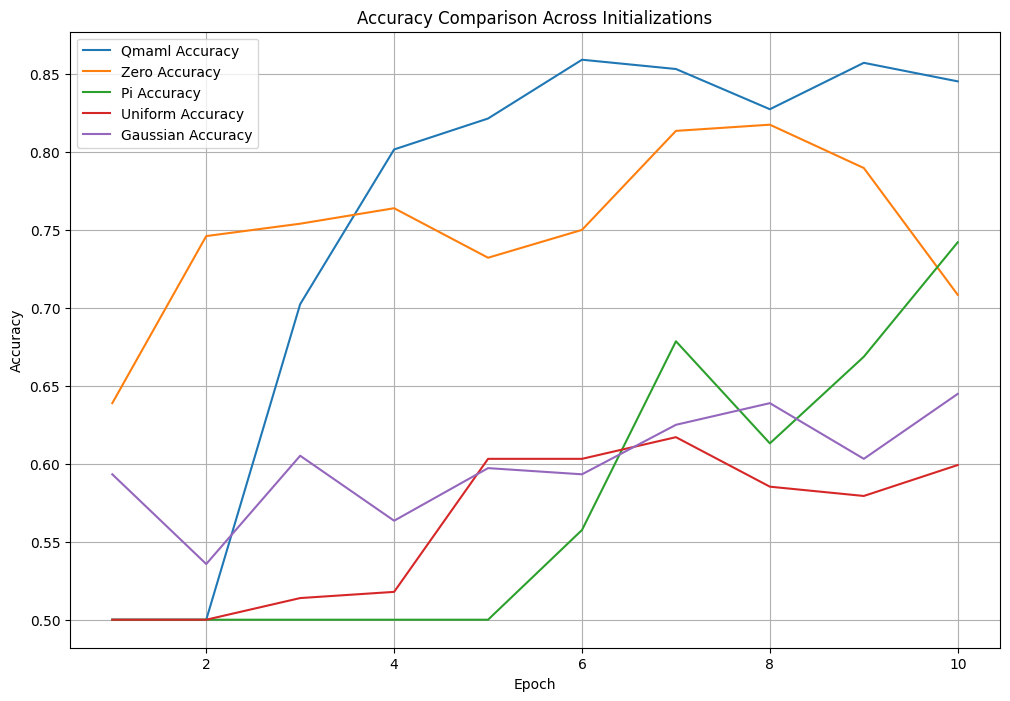

In [15]:
# --- Cell 11: Run Experiments ---
# Test different initialization techniques
initialization_types = ["qmaml", "zero", "pi", "uniform", "gaussian"]
results = {}

# Generate meta-tasks for the test set
test_meta_tasks = generate_meta_tasks(
    test_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

for init_type in initialization_types:
    print(f"Testing initialization: {init_type}")
    # Initialize PQC with the current initialization type
    pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, init_type=init_type)
    # Combine CNN and PQC into the hybrid model
    hybrid_model = HybridModel(cnn_extractor, pqc_model)
    # Perform meta-training and store results
    training_results = outer_loop_meta_update(
        hybrid_model,
        meta_tasks,
        test_meta_tasks,
        config.OUTER_LR,
        config.EVAL_METRICS,
    )
    results[init_type] = training_results
    # Plot training results for the current initialization
    plot_training_results(training_results, init_type)

# Compare results across all initialization techniques
plot_comparison(results)